cuda
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=0628bf365b00ef4f68c573ac4cebab549e9e730a4b1dbb1ab9b6b03b6d479126
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Unix-like
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Cloning into 'HeartRateRegression'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (158/158), don

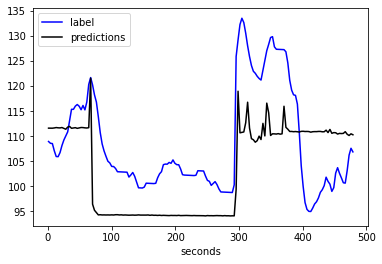

Validation


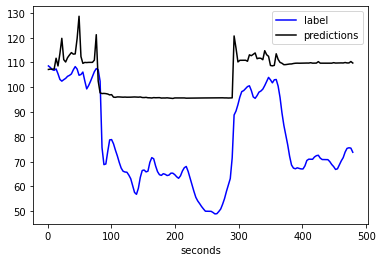

Train


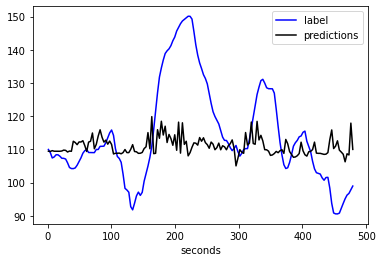

[11/100]: loss_train: 11.675 loss_val 14.406 loss_ts 13.793
[12/100]: loss_train: 11.491 loss_val 14.509 loss_ts 13.670
[13/100]: loss_train: 11.632 loss_val 14.496 loss_ts 13.782
[14/100]: loss_train: 12.295 loss_val 14.513 loss_ts 14.209
[15/100]: loss_train: 11.691 loss_val 14.403 loss_ts 13.616
[16/100]: loss_train: 11.299 loss_val 14.472 loss_ts 14.138
[17/100]: loss_train: 11.304 loss_val 14.862 loss_ts 14.597
[18/100]: loss_train: 11.180 loss_val 14.523 loss_ts 13.964
[19/100]: loss_train: 11.286 loss_val 14.754 loss_ts 13.909
[20/100]: loss_train: 11.951 loss_val 15.162 loss_ts 15.941
Test


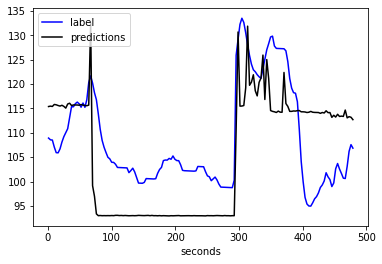

Validation


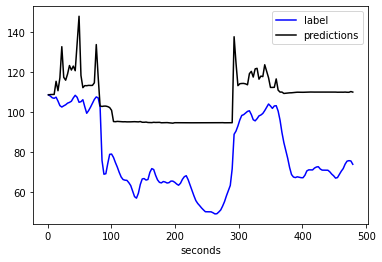

Train


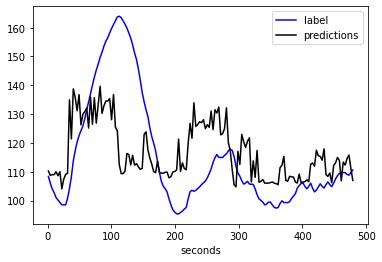

best val epoch: 21
[21/100]: loss_train: 11.273 loss_val 13.971 loss_ts 14.064
[22/100]: loss_train: 11.303 loss_val 14.764 loss_ts 14.112
[23/100]: loss_train: 10.990 loss_val 14.263 loss_ts 14.228
[24/100]: loss_train: 10.930 loss_val 14.875 loss_ts 14.039
[25/100]: loss_train: 11.049 loss_val 14.778 loss_ts 13.988
[26/100]: loss_train: 10.853 loss_val 14.829 loss_ts 14.567
[27/100]: loss_train: 10.884 loss_val 14.431 loss_ts 14.299
[28/100]: loss_train: 10.705 loss_val 14.011 loss_ts 14.366
[29/100]: loss_train: 11.037 loss_val 14.501 loss_ts 14.260
best val epoch: 30
[30/100]: loss_train: 11.236 loss_val 13.467 loss_ts 14.876
Test


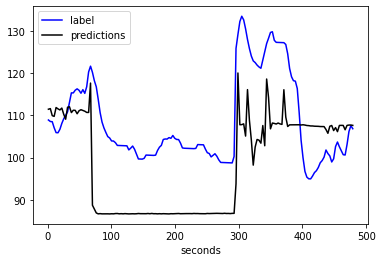

Validation


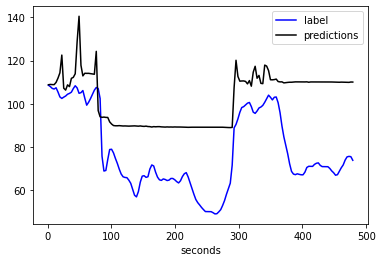

Train


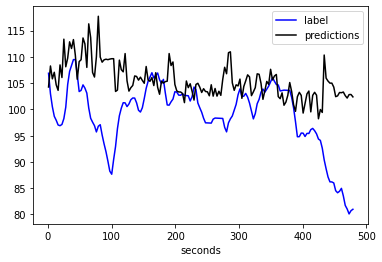

[31/100]: loss_train: 11.070 loss_val 14.837 loss_ts 14.070
[32/100]: loss_train: 10.635 loss_val 14.617 loss_ts 14.008
[33/100]: loss_train: 10.850 loss_val 14.349 loss_ts 13.978
[34/100]: loss_train: 11.166 loss_val 14.238 loss_ts 14.342
[35/100]: loss_train: 10.417 loss_val 14.567 loss_ts 14.491
[36/100]: loss_train: 10.601 loss_val 14.998 loss_ts 15.343
[37/100]: loss_train: 10.601 loss_val 14.486 loss_ts 16.152
[38/100]: loss_train: 10.484 loss_val 14.490 loss_ts 14.911
[39/100]: loss_train: 10.313 loss_val 14.549 loss_ts 14.918
[40/100]: loss_train: 10.201 loss_val 14.390 loss_ts 14.538
Test


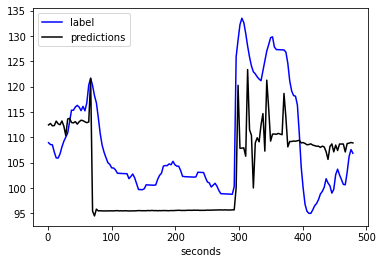

Validation


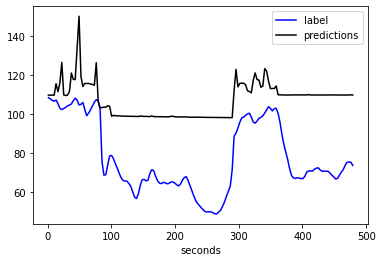

Train


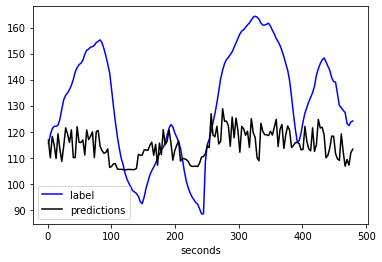

[41/100]: loss_train: 10.186 loss_val 14.319 loss_ts 14.065
[42/100]: loss_train: 10.100 loss_val 14.020 loss_ts 15.104
[43/100]: loss_train: 10.274 loss_val 14.584 loss_ts 14.879
[44/100]: loss_train: 10.432 loss_val 13.533 loss_ts 16.041
[45/100]: loss_train: 10.543 loss_val 15.536 loss_ts 14.915
[46/100]: loss_train: 10.271 loss_val 14.759 loss_ts 14.329
[47/100]: loss_train: 10.049 loss_val 15.086 loss_ts 14.833
[48/100]: loss_train: 9.694 loss_val 14.848 loss_ts 16.006
[49/100]: loss_train: 9.980 loss_val 14.498 loss_ts 14.790
[50/100]: loss_train: 10.147 loss_val 14.179 loss_ts 16.336
Test


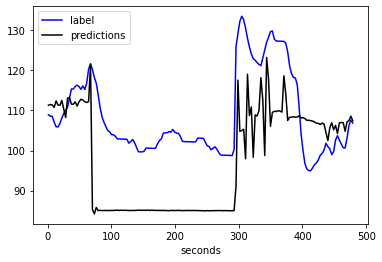

Validation


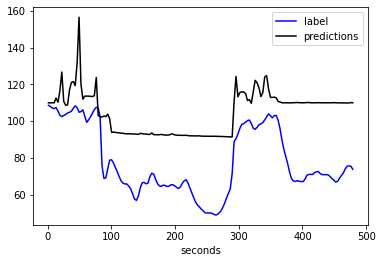

Train


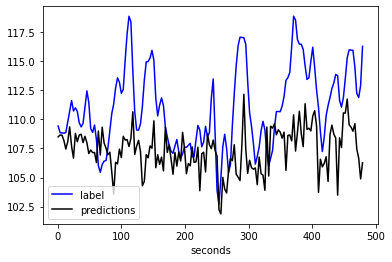

[51/100]: loss_train: 10.702 loss_val 14.753 loss_ts 13.636
[52/100]: loss_train: 10.393 loss_val 14.695 loss_ts 14.189
[53/100]: loss_train: 9.931 loss_val 15.284 loss_ts 15.550
[54/100]: loss_train: 10.721 loss_val 14.577 loss_ts 14.608
[55/100]: loss_train: 9.628 loss_val 14.528 loss_ts 15.908
[56/100]: loss_train: 9.578 loss_val 14.496 loss_ts 16.150
[57/100]: loss_train: 10.410 loss_val 15.179 loss_ts 14.492
[58/100]: loss_train: 9.812 loss_val 14.159 loss_ts 15.453
[59/100]: loss_train: 9.417 loss_val 14.672 loss_ts 16.377
[60/100]: loss_train: 9.620 loss_val 14.184 loss_ts 16.277
Test


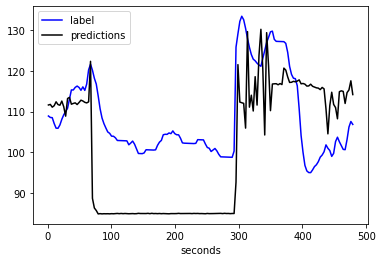

Validation


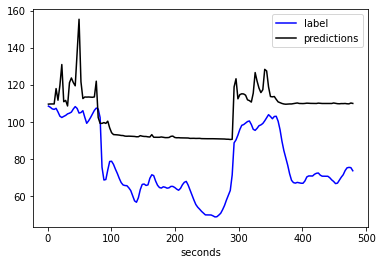

Train


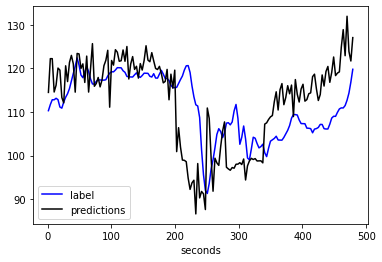

[61/100]: loss_train: 10.479 loss_val 14.422 loss_ts 15.074
[62/100]: loss_train: 10.368 loss_val 15.312 loss_ts 18.416
[63/100]: loss_train: 9.836 loss_val 15.482 loss_ts 17.907


In [ ]:

#%%
import torch

args = {
    'epoch_num': 100,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'batch_size': 4,     # Mini-batch size. 600
    'batch_test': 4,     # size of test batch
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

dataset_name = "PAMAP2"
model_type = "CnnIMU"
#"OurConvLSTM", "AttentionTransformer", "DeepConvLSTM", "CnnIMU", FCNN

val_sub = 3
for ts_sub in [7]:#[0, 1, 2, 4, 5, 6, 7]: #2,6]:#[6,7,2,0,1,3,5]:


  ! pip install wget
  import os
  import torch
  import pandas as pd
  import numpy as np
  import torch
  from torch import nn


  ssh_config = """
  Host github.com
    IdentityFile ~/.ssh/github.pem
    User davipeag
    StrictHostKeyChecking no
  """

  if os.name == 'nt':
    base_path = ""
    REPO_DIR = "."
    STORE_DIR ="." 
    print("Windows")
  else:
    print("Unix-like")
    REPO_DIR = "/tmp/HeartRateRegression"
    from google.colab import drive
    drive.mount('/content/drive')
    GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
    DATA_PATH = "/content/drive/My\ Drive/deeplearning_project/normalized.zip"
    STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
    !mkdir ~/.ssh
    !cp -u {GIT_PATH} ~/.ssh/
    !chmod u=rw,g=,o= ~/.ssh/github.pem
    !echo "{ssh_config}" > ~/.ssh/config
    !chmod u=rw,g=,o= ~/.ssh/config
    ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
    ! (cd {REPO_DIR} && git pull )
    import sys
    sys.path.append(REPO_DIR)


  def git_push():
    if os.name == 'nt':
      pass
    else:
      ! git config --global user.email "daviaguiar@outlook.com"
      ! git config --global user.name "Davi Pedrosa de Aguiar"
      print("going to push")
      ! (cd {REPO_DIR} && git pull && cd -)
      ! (cd {REPO_DIR} && git add . && git commit -m "from colab" && git push)

  def git_pull():
    if os.name == 'nt':
      pass
    else:
      ! git config --global user.email "daviaguiar@outlook.com"
      ! git config --global user.name "Davi Pedrosa de Aguiar"
      print("going to push")
      ! (cd {REPO_DIR} && git pull && cd -)
      
    
  git_push()



  from data_utils import (
      Pamap2Handler, cross_validation_split)

  from default_utils import DefaultPamapPreprocessing, FcPamapPreprocessing
  from preprocessing_utils import (OurConvLstmToAttentionFormat, OurConvLstmToCnnImuFormat)

  from models_utils import OurConvLstmDataset, make_loader, reset_seeds
  from models_utils import DatasetXY

  from default_utils import TrainOurConvLSTM, TrainXY
  from default_utils import make_our_conv_lstm, make_attention_transormer_model, make_fcnn
  from torch import nn



  reset_seeds()

  ##%%

  dataset_handler = Pamap2Handler(os.path.join(REPO_DIR, ".."))

  dfs = [dataset_handler.get_protocol_subject(s) for s in [1,2,3,4,5,6,7,8,9]]
  #df_full = pd.concat(dfs)
  
  #use_dfs = dfs[:8]

  preprocessing_options = {
      "OurConvLSTM": DefaultPamapPreprocessing(ts_count = 300, donwsampling_ratio = 1),
      "AttentionTransformer": DefaultPamapPreprocessing(
        ts_count = 300, donwsampling_ratio = 1, last_transformer=OurConvLstmToAttentionFormat()),
      "DeepConvLSTM": DefaultPamapPreprocessing(last_transformer=OurConvLstmToCnnImuFormat()),
      "CnnIMU": DefaultPamapPreprocessing(last_transformer=OurConvLstmToCnnImuFormat()),
      "FCNN": FcPamapPreprocessing(),
  }
  preprocessor =preprocessing_options[model_type]

  ##%%

  #preprocessor.transformers.fit(df_full)

  ###begin attempt
  train_ts = [0,1,2,3,4,5,6,7] 
  val_idx = train_ts.index(val_sub)
  ts_idx = train_ts.index(ts_sub)
  train_indices = list(filter(lambda i: i not in [val_idx, ts_idx], train_ts))
  #train_idxes = train_ts[:val_idx] + train_ts[val_idx+1:] 

  xy_tr = [preprocessor.transformers.transform(dfs[i]) for i in train_indices]
  xy_val = [preprocessor.transformers_ts.transform(dfs[val_idx])]
  xy_ts = [preprocessor.transformers_ts.transform(dfs[ts_idx])]

  print(train_indices)
  print(ts_sub)


  #%% end attempt
  #xy_tr, xy_val, xy_ts = cross_validation_split(use_dfs, preprocessor.transformers, preprocessor.transformers_ts, preprocessor.transformers_ts, val_sub, ts_sub)

  del dfs
  #del df_full

  dataset_cls_options = {
      "OurConvLSTM": OurConvLstmDataset,
      "AttentionTransformer": DatasetXY,
      "DeepConvLSTM": DatasetXY,
      "CnnIMU": DatasetXY,
      "FCNN": DatasetXY,
  }


  dataset_cls = dataset_cls_options[model_type]

  loader_tr = make_loader(xy_tr, dataset_cls, batch_size=args["batch_size"], shuffle=True)
  loader_val = make_loader(xy_val, dataset_cls, batch_size=args["batch_test"],shuffle=False)
  loader_ts = make_loader(xy_ts, dataset_cls, batch_size=args["batch_test"], shuffle=False)

  # #%%
  # x,y = loader_tr.__iter__().__next__()
  # x.shape, y.shape

  ##%%
  from default_utils import make_cnn_imu2
  from default_utils import make_deep_conv_lstm


  net_options = {
      "OurConvLSTM": lambda : make_our_conv_lstm(40,1),
      "AttentionTransformer": lambda: make_attention_transormer_model(args["device"]),
      "DeepConvLSTM": lambda : make_deep_conv_lstm(),
      "CnnIMU": lambda : make_cnn_imu2(),
      "FCNN": lambda : make_fcnn()
  }

  reset_seeds()

  net = net_options[model_type]().to(args["device"])
  criterion = nn.L1Loss().to(args["device"]) 
  optimizer = torch.optim.Adam(net.parameters(), lr=args["lr"],
                              weight_decay=args["weight_decay"])

  ##%%


  basic_training_parameters = {
      "net": net,
      "criterion": criterion,
      "optimizer": optimizer,
      "loader_tr": loader_tr,
      "loader_val": loader_val,
      "loader_ts": loader_ts,
      "normdz": preprocessor.normdz,
      "ztransformer": preprocessor.ztransformer,
      "device": args["device"]
  }


  trainer_options = {
      "OurConvLSTM": lambda : TrainOurConvLSTM(**basic_training_parameters),
      "AttentionTransformer": lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: x[:,1, 0, -1].reshape(-1,1)
      ),
      "CnnIMU":lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: np.mean(x[:,0,200:300, 0], axis=1).reshape(-1,1)
      ),
      "DeepConvLSTM":lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: np.mean(x[:,0,200:300, 0], axis=1).reshape(-1,1)
      ),
      "FCNN":lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: x[:,0, 0].reshape(-1,1)
      ), 

  }

  trainer = trainer_options[model_type]()


  run_output = trainer.train_epochs(args["epoch_num"])


  #%%

  state_dict_name = f"trained_models/{model_type}ts_{ts_sub}_val_{val_sub}.pkl"
  torch.save(run_output["best_val_model"], os.path.join(STORE_DIR, state_dict_name))

  git_push()


# %%


In [ ]:
len(use_dfs)